In [ ]:
import pandas as pd
import numpy as np
# from.tools import *
from Multivariate_Markov_Switching_Model.tools import *
from Multivariate_Markov_Switching_Model.MSVAR import *
from Multivariate_Markov_Switching_Model.tools import _2dim
import numpy as np
import os
# os.chdir("MSVAR")
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.interpolate import interp1d
from Multivariate_Markov_Switching_Model.MSVAR import *
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [ ]:


def fill(series):
    # print(series.name)
    if any(series.isna()):

        nan_loc = pd.Index(series.values).get_loc(np.nan)
        if isinstance(nan_loc, np.ndarray):
            all_loc = np.arange(len(series))

            x = np.setdiff1d(all_loc, nan_loc)
            y = series.dropna().values

            f = interp1d(x, y, 'slinear')
            new_x = nan_loc[(nan_loc >= x[0]) & (nan_loc <= x[-1])]
            new_y = f(new_x)

            interpolate = pd.Series(new_y, index=new_x)
            ori = pd.Series(y, index=x)

            _ = pd.concat([interpolate, ori]).reindex(all_loc)
            _.index = series.index
            return _
        else:
            return series
    else:
        return series



price = pd.read_pickle("Data/Financial/Index/daily/000001_daily_price.pkl")['close']

p = price.resample("M").last()


industry = pd.read_excel("Data/Financial/Macro/工业增加值-月.xls",index_col=0,header=2,nrows=2).T

industry.index = pd.DatetimeIndex(industry.index.str[:4]+"-"+industry.index.str[5:-1].str.zfill(2)+"-01")

industry = industry.resample("M").last()

industry_increase = industry['工业增加值同比增长(%)']
industry_increase = fill(industry_increase).dropna()


# industry_increase.reindex(smooth_probabilities.index).plot()

In [ ]:
data = pd.read_pickle("Multivariate_Markov_Switching_Model/test_data.pkl")
data = data[['M2',"股市",'实体经济']]
model = pd.read_pickle("Multivariate_Markov_Switching_Model/m2-股市-L3-K3.pkl").loc[0]
smooth_probabilities = pd.DataFrame(model.smooth_probabilities(),index=data.index[-model.x.shape[0]:])
filtered_probabilities = pd.DataFrame(model.results['filtered_probabilities'][1:],index = data.index[-model.x.shape[0]:])
p_predicted_joint = pd.DataFrame(model.results['p_predicted_joint'],index=data.index[-model.x.shape[0]:])
price = pd.read_pickle("Data/Financial/Index/daily/000001_daily_price.pkl")['close']

# p = price.resample("M").last().reindex(smooth_probabilities.index)
p = (industry_increase).reindex(smooth_probabilities.index)

import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(smooth_probabilities.shape[1],1,sharex=True,figsize=(10,6))
for i in smooth_probabilities:
    smooth_probabilities[i].plot(ax=ax[i],color='#984B4B')
    filtered_probabilities[i].plot(ax=ax[i],color="#4F9D9D",ls='-.')
    p_predicted_joint[i].plot(ax=ax[i],color='#FF8F59',ls='--')
#     ax[i].set(title="Regime %s"%i)
    ax[0].legend(['Smoothed','Filtered','Predicted'],loc='upper right')    
    ax[i] = ax[i].twinx()
    p.plot(ax=ax[i],color='k',alpha=0.3)
    ax[0].legend(['工业同比增加'],loc='lower left')    
ax[0].set_title("紧缩")
ax[1].set_title("平稳")
ax[2].set_title("通胀")

fig.tight_layout()


In [ ]:
np.corrcoef(filtered_probabilities[2],p)

In [ ]:
p_j, p_ij, b, d, var_mat, inv_var_mat,det_inv_var_mat = model.convert_param(model.results['constrained'])

In [ ]:
p_ij

In [ ]:
_ = model.summary()

In [ ]:
pd.Series(_).to_pickle("Multivariate_Markov_Switching_Model//model1_summary.pkl")

In [1]:
import warnings 
warnings.filterwarnings('ignore') 
from Multivariate_Markov_Switching_Model.MSVAR import *
%matplotlib inline
from Multivariate_Markov_Switching_Model.tools import _2dim


data = []

with open("Multivariate_Markov_Switching_Model/test_data/MSVARUN.txt") as f:
    for _ in f.readlines():
        data.append(_.strip().split("\t"))
data = pd.DataFrame(data)

s = data.set_index([1,0]).replace(".",np.nan)[2].astype(float).rename_axis(['year','month'])

apr = data.set_index([1,0]).replace(".",np.nan)[3].astype(float).rename_axis(['year','month'])

apriori = apr[apr.index.get_loc(("1967","7")):apr.index.get_loc(("2004","3"))].values

k_lag = 2

_ = np.log(s).diff(k_lag)*100

s = _[_.index.get_loc(("1967","2"))+k_lag:_.index.get_loc(("2004","2"))+1]

s = ((s-s.mean())/s.std()).values[:,np.newaxis]
y = s

z = generate_lagged_regressors(s,3).values
x = [1]*z.shape[0]
x = _2dim(np.array(x))

model = Markov_Multivarite_Regression(y[-z.shape[0]:],x,z,2,2,"full",apriori=None)
# model = Multivariate_Markov_Switching_Model(y[-z.shape[0]:],x,None,2,2,"full",apriori=None)

res = model.fit()



In [2]:
res

array([[ 0.85089924],
       [ 0.97339873],
       [-0.80059507],
       [ 0.14887296],
       [ 0.70574205],
       [ 0.34950403],
       [ 0.6414498 ],
       [-0.45878331],
       [ 0.34911898]])

In [3]:
summary = model.summary()

calculating gradian and hessian matrix..pls be patient


In [4]:
summary[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Markov Switching Multivariate Model Results                  
==============================================================================
Dep. Variable:                 ['y0']   No. Observations:                  440
Date:                Fri, 17 Apr 2020   Covariance Type                   full
Time:                    ['21:34:54']   Regimes                              2
                                        Log Likelihood                 449.278
                         Regime 0 Switching Parameters                         
===============================================================================
                           coef         std err               t           p>|t|
-------------------------------------------------------------------------------
y0.beta0                -0.8006          0.2243         -3.5699          0.0004
                         Regime 1 Switching Parameters                         
===============================================================================
                           coef         std err               t           p>|t|
-------------------------------------------------------------------------------
y0.beta0                 0.1489          0.0519          2.8709          0.0043
                            Non Switching Parameters                           
===============================================================================
                           coef         std err               t           p>|t|
-------------------------------------------------------------------------------
y0.delta0                0.6414          0.0578         11.1001             0.0
y0.delta1               -0.4588          0.0512         -8.9583             0.0
y0.delta2                0.3491           0.051          6.8521             0.0
                          Regime transition parameters                         
===============================================================================
                          coef1         std err               t           p>|t|
-------------------------------------------------------------------------------
p[0-0]                   0.8509          0.0797         10.6763             0.0
p[0-1]                   0.9734          0.0129         75.6457             0.0
===============================================================================
"""

In [5]:
summary[1]

,Estimates,Standard-errors,T,P-values
0,0.8509,0.0797,10.6763,0.0000
1,0.9734,0.0129,75.6457,0.0000
2,-0.8006,0.2243,-3.5699,0.0004
3,0.1489,0.0519,2.8709,0.0043
4,0.7057,0.2004,3.5216,0.0005
5,0.3495,0.0314,11.1178,0.0000
6,0.6414,0.0578,11.1001,0.0000
7,-0.4588,0.0512,-8.9583,0.0000
8,0.3491,0.0510,6.8521,0.0000


In [6]:
print("="*30+"Transition Matrix"+"="*30)
print(pd.DataFrame(summary[2]))

==============================Transition Matrix==============================
          0         1
0  0.850899  0.026601
1  0.149101  0.973399


In [7]:
print("="*30+"Sigma"+"="*30)
print(summary[3])

==============================Sigma==============================
[[0.70574205 0.34950403]]


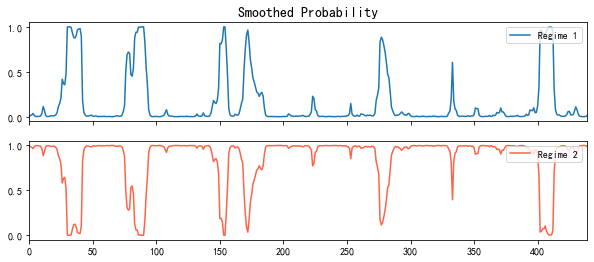

In [8]:
_sp = pd.DataFrame(model.smooth_probabilities())
fig,ax = plt.subplots(2,1,figsize=(10,4),sharex=True)
_sp[0].plot(ax=ax[0])
_sp[1].plot(ax=ax[1],color='tomato')
_ = ax[0].set_title("Smoothed Probability",fontsize=14)
ax[0].legend(["Regime 1"],loc='upper right')
ax[1].legend(["Regime 2"],loc='upper right')
